# **Taylor diagrams for spatial patterns**

In [1]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *
from taylorDiagram import TaylorDiagram, taylor_scores
import xesmf as xe

import warnings

warnings.filterwarnings("ignore", message = (".+F_CONTIGUOUS.+"))
cproj = cartopy.crs.PlateCarree()

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/xclim/indices/fire/_cffwis.py:216: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _day_length(lat: int | float, mth: int):  # pragma: no cover
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/xclim/indices/fire/_cffwis.py:236: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _day_length

## **Regrid model data to target grid**

Use conservative_normed to avoid edge effects around missing values

In [2]:
def transform_xy(x, y, crs_in = None, crs_out = None):
    
    # transform 1d or 2d coords into 2d coords in another projection
    
    x = np.array(x)
    y = np.array(y)
    
    if x.ndim == 1:
        # tile 1d coordinates into 2d arrays of x, y per cell
        x_2d = np.tile(np.array(x), (len(y), 1))
        y_2d = np.tile(np.array([y]).transpose(), (1, len(x)))
    else:
        # coordinates are already 2d arrays
        x_2d = x
        y_2d = y
    
    if crs_in is None or crs_out is None:
        # return tiled points on original grid
        return x_2d, y_2d
        
    else:
        # transform and return
        xy_transf = crs_out.transform_points(crs_in, x_2d, y_2d)
        return xy_transf[:,:,0], xy_transf[:,:,1]
    

def vertices_from_centres(x_coords, y_coords, crs_in = None, crs_out = None):
    
    # Compute vertices on regular grid of 1d x, y coordinates
    
    if np.array(x_coords).ndim > 1 or np.array(y_coords).ndim > 1:
        print("Coordinates must be one-dimensional")
        return
    
    # compute offsets needed to find midpoints
    x_offset = np.diff(x_coords) / 2
    y_offset = np.diff(y_coords) / 2
    
    # use offsets to obtain vectors of cell midpoints (adds 1 to each dimension)
    x_bounds = xr.concat([x_coords[0] - x_offset[0], x_coords[:-1] + x_offset, x_coords[-1] + x_offset[-1]], dim = x_coords.dims[0])
    y_bounds = xr.concat([y_coords[0] - y_offset[0], y_coords[:-1] + y_offset, y_coords[-1] + y_offset[-1]], dim = y_coords.dims[0])
    
    # expand vectors of bounds to grid of corners (& transform projection if necessary)
    xvert, yvert = transform_xy(x_bounds, y_bounds, crs_in = crs_in, crs_out = crs_out)
    
    return(xvert, yvert)


def add_grid(da, x_coords, y_coords, crs_in = None, crs_out = None):
    
    # return grid with vertices based on regular grid of 1d x, y coordinates, to be used in regridding using xe.Regridder
    if type(x_coords) == str: x_coords = da[x_coords]
    if type(y_coords) == str: y_coords = da[y_coords]
    
    if np.array(x_coords).ndim > 1 or np.array(y_coords).ndim > 1:
        print("Coordinates must be one-dimensional")
        return
    
    lon, lat = transform_xy(x_coords, y_coords, crs_in, crs_out)
    lon_b, lat_b = vertices_from_centres(x_coords, y_coords, crs_in, crs_out)
    
    da = da.assign_coords(lon = ([y_coords.name, x_coords.name], lon, x_coords.attrs), lat = ([y_coords.name, x_coords.name], lat, y_coords.attrs),
                          lon_b = ([y_coords.name+"_b", x_coords.name+"_b"], lon_b), lat_b = ([y_coords.name+"_b", x_coords.name+"_b"], lat_b))
    
    return da

### **CMIP6**

In [3]:
era5 = xr.open_dataset("ann_pr_era5_1980_2010.nc")

In [ ]:
# has stopped working for some reason, unclear why
regridded_cmip6 = []
varnm = "pr"
fl = glob.glob(varnm+"_spatial/*.nc")
for fnm in fl:
    ds = xr.open_dataset(fnm)
    if "height" in ds.coords: ds = ds.reset_coords("height", drop = True)
    regrid = xe.Regridder(ds, era5, method = "conservative_normed", unmapped_to_nan = True)
    regridded_cmip6.append(regrid(ds).expand_dims(run = ["_".join(fnm.split("_")[3:-1])]).rename(varnm))
regridded_cmip6 = xr.concat(regridded_cmip6, "run")
regridded_cmip6 = regridded_cmip6.isel(lon = slice(5,-1), lat = slice(5,-5)) # trim to avoid edge effects
regridded_cmip6.to_netcdf("ann_"+varnm+"_cmip6-regridded-to-era5.nc")

### **CORDEX**

In [18]:
crs = {'CLMcom-ETH-COSMO-crCLIM-v1-1' : cartopy.crs.RotatedPole(pole_longitude=-123.4, pole_latitude = 79.95),
       'GERICS-REMO2015' : cartopy.crs.RotatedPole(pole_longitude=-123.34, pole_latitude = 79.95), 
       'ICTP-RegCM4-7' : cartopy.crs.ObliqueMercator(central_longitude=70.0, central_latitude=13.0, false_easting=-12500.0, false_northing=-12500.0, scale_factor=1.0, azimuth=89.999999, globe=None)}

In [19]:
era5 = xr.open_dataset("ann_pr_era5_1980_2010.nc")

# add grid to ERA5 for easier regridding
lonvert, latvert = vertices_from_centres(era5.lon, era5.lat)
era5["lon_b"] = (["latb", "lonb"], lonvert)
era5["lat_b"] = (["latb", "lonb"], latvert)

In [20]:
regridded_cordex = []
varnm = "tmax"
fl = glob.glob("cordex/"+varnm+"*.nc")
for fnm in fl:
    ds = xr.open_dataset(fnm)
    ccrs = crs[re.sub(".nc", "", fnm.split("_")[-1])]
    if "height" in ds.coords: ds = ds.reset_coords("height", drop = True)
    
    if "rlon" in ds.dims:
        ds = add_grid(ds, ds.rlon, ds.rlat, crs_in = ccrs, crs_out = cproj)
    else:
        ds = add_grid(ds, ds.x, ds.y, crs_in = ccrs, crs_out = cproj)
        
    regrid = xe.Regridder(ds, era5, method = "conservative_normed", unmapped_to_nan = True)
    regridded = regrid(ds).reset_coords(drop = True).squeeze().expand_dims(run = [re.sub(".nc", "", "_".join(fnm.split("_")[2:]))])
    
    regridded_cordex.append(regridded)

regridded_cordex = xr.concat(regridded_cordex, "run")
regridded_cordex.to_netcdf("ann_"+varnm+"_cordex-regridded-to-era5.nc")

---
## **Taylor diagrams**

### **Precipitation**

In [80]:
regridded_cmip6 = xr.open_dataset("ann_pr_cmip6-regridded-to-era5.nc").pr.sortby("run") / 365

era5 = xr.open_dataset("ann_pr_era5_1980_2010.nc").tp

In [75]:
corrs, sds = taylor_scores(regridded_cmip6, era5)
ref_sd = era5.std().values

In [76]:
max_sd = max(np.ceil(max(sds)) / ref_sd, 1.1)
min_corr = min(corrs)

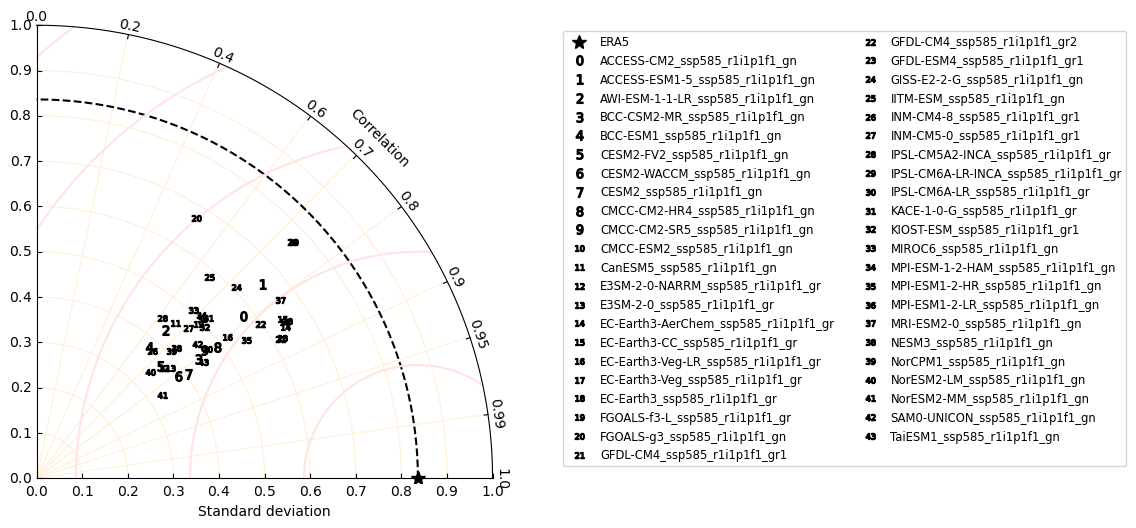

In [77]:
fig = plt.figure(figsize = (6,6), dpi= 100, facecolor='w', edgecolor='k')
td = TaylorDiagram(ref_sd, fig = fig, label = "ERA5", srange = (0, max_sd), extend = False)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

for i in range(len(corrs)):
    td.add_sample(sds[i], corrs[i], marker = "$"+str(i)+"$", ms = 7, ls = '', mfc = "tab:blue", mec = "black", label = regridded_cmip6.run.values[i])
    
fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (1,0.5), ncols = 2)

### **Maximum temperatures**

In [82]:
regridded_cmip6 = xr.open_dataset("ann_tasmax_models-regridded-to-era5.nc").tasmax.sortby("run")
era5 = xr.open_dataset("ann_tmax_era5_1980_2010.nc").tmax

In [83]:
corrs, sds = taylor_scores(regridded_cmip6, era5)
ref_sd = era5.std().values

In [84]:
max_sd = max(np.ceil(max(sds)) / ref_sd, 1.1)
min_corr = min(corrs)

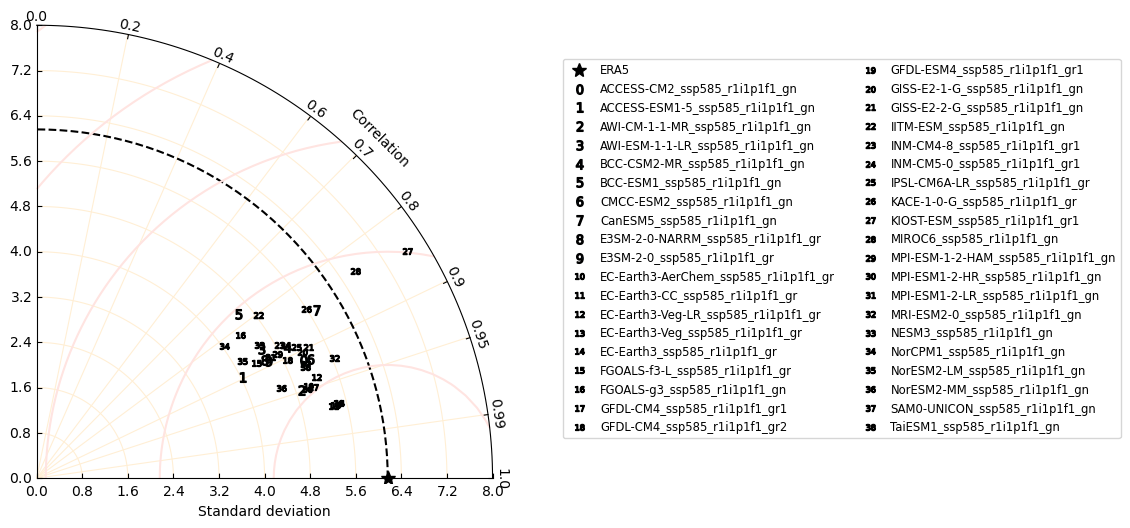

In [85]:
fig = plt.figure(figsize = (6,6), dpi= 100, facecolor='w', edgecolor='k')
td = TaylorDiagram(ref_sd, fig = fig, label = "ERA5", srange = (0, max_sd), extend = False)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

for i in range(len(corrs)):
    td.add_sample(sds[i], corrs[i], marker = "$"+str(i)+"$", ms = 7, ls = '', mfc = "tab:blue", mec = "black", label = regridded_cmip6.run.values[i])
    
fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (1,0.5), ncols = 2)

### **Minimum temperatures**

In [86]:
regridded_cmip6 = xr.open_dataset("ann_tasmin_models-regridded-to-era5.nc").tasmin.sortby("run")
era5 = xr.open_dataset("ann_tmin_era5_1980_2010.nc").tmin

In [87]:
corrs, sds = taylor_scores(regridded_cmip6, era5)
ref_sd = era5.std().values

In [88]:
max_sd = max(np.ceil(max(sds)) / ref_sd, 1.1)
min_corr = min(corrs)

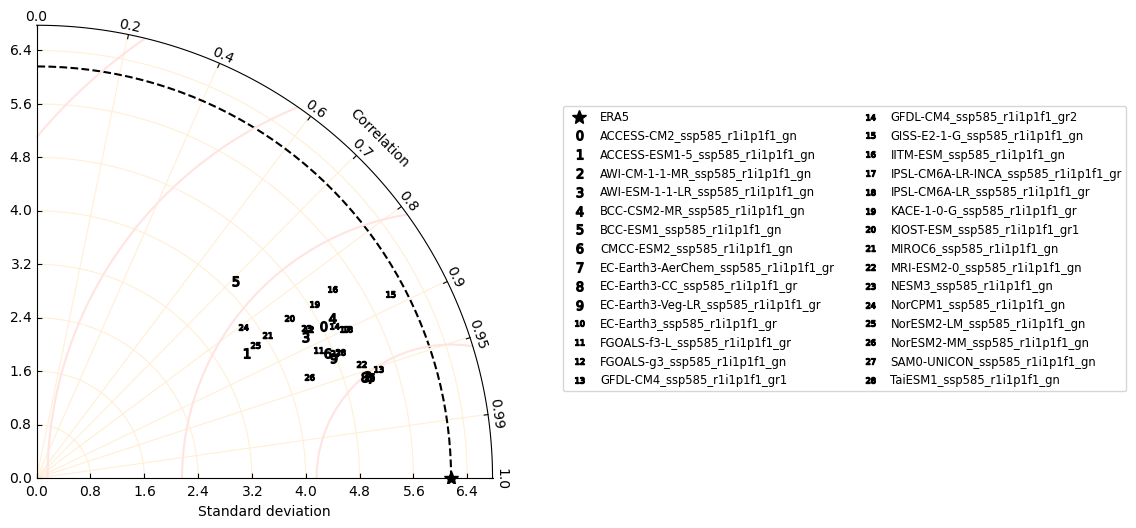

In [89]:
fig = plt.figure(figsize = (6,6), dpi= 100, facecolor='w', edgecolor='k')
td = TaylorDiagram(ref_sd, fig = fig, label = "ERA5", srange = (0, max_sd), extend = False)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

for i in range(len(corrs)):
    td.add_sample(sds[i], corrs[i], marker = "$"+str(i)+"$", ms = 7, ls = '', mfc = "tab:blue", mec = "black", label = regridded_cmip6.run.values[i])
    
fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'), loc='center left', bbox_to_anchor = (1,0.5), ncols = 2)

## **precip + tmax + tmin**

In [21]:
# load CMIP6 spatial patterns
pr_cmip6 = xr.open_dataset("ann_pr_cmip6-regridded-to-era5.nc").pr.sortby("run") / 365
tmax_cmip6 = xr.open_dataset("ann_tasmax_cmip6-regridded-to-era5.nc").tasmax.sortby("run")
tmin_cmip6 = xr.open_dataset("ann_tasmin_cmip6-regridded-to-era5.nc").tasmin.sortby("run")

pr_cordex = xr.open_dataset("ann_pr_cordex-regridded-to-era5.nc").pr.sortby("run") / 365
tmax_cordex = xr.open_dataset("ann_tmax_cordex-regridded-to-era5.nc").tasmax.sortby("run")

# filter to retain only those models with historical & SSP runs
cmip6_models = sorted(['EC-Earth3-Veg-LR', 'IPSL-CM6A-LR', 'KACE-1-0-G', 'EC-Earth3-CC', 'CMCC-ESM2', 'NorESM2-LM', 'EC-Earth3', 'FGOALS-g3', 'MRI-ESM2-0', 'ACCESS-CM2',
                       'MIROC6', 'GFDL-CM4', 'NorESM2-MM', 'TaiESM1', 'ACCESS-ESM1-5'])
pr_cmip6, tmax_cmip6, tmin_cmip6 = [da.sel(run = [r.split("_")[0] in cmip6_models for r in da.run.values]) for da in [pr_cmip6, tmax_cmip6, tmin_cmip6]]

# load ERA5 spatial patterns
pr_era5, tmax_era5, tmin_era5 = [xr.open_dataset("ann_"+varnm+"_era5_1980_2010.nc")[re.sub("pr", "tp", varnm)] for varnm in ["pr", "tmax", "tmin"]]

cmip6_models = pr_cmip6.run.values
cordex_models = pr_cordex.run.values

In [37]:
cordex_colours = {'ICHEC-EC-EARTH' : "tab:blue",
                  'MIROC-MIROC5' : "tab:orange",
                  'MOHC-HadGEM2-ES' : "mediumslateblue",
                  'MPI-M-MPI-ESM-LR' : "chartreuse",
                  'MPI-M-MPI-ESM-MR' : "green",
                  'NCC-NorESM1-M' : "purple"}

cordex_markers = {'CLMcom-ETH-COSMO-crCLIM-v1-1' : "o", 
                  'GERICS-REMO2015' : "s",
                  'ICTP-RegCM4-7' : "D"}

In [38]:
# calculate scores for Taylor diagrams
pr_scores = taylor_scores(xr.concat([pr_cmip6, pr_cordex], "run"), pr_era5)
tmax_scores = taylor_scores(xr.concat([tmax_cmip6, tmax_cordex], "run"), tmax_era5)
tmin_scores = taylor_scores(tmin_cmip6, tmin_era5)

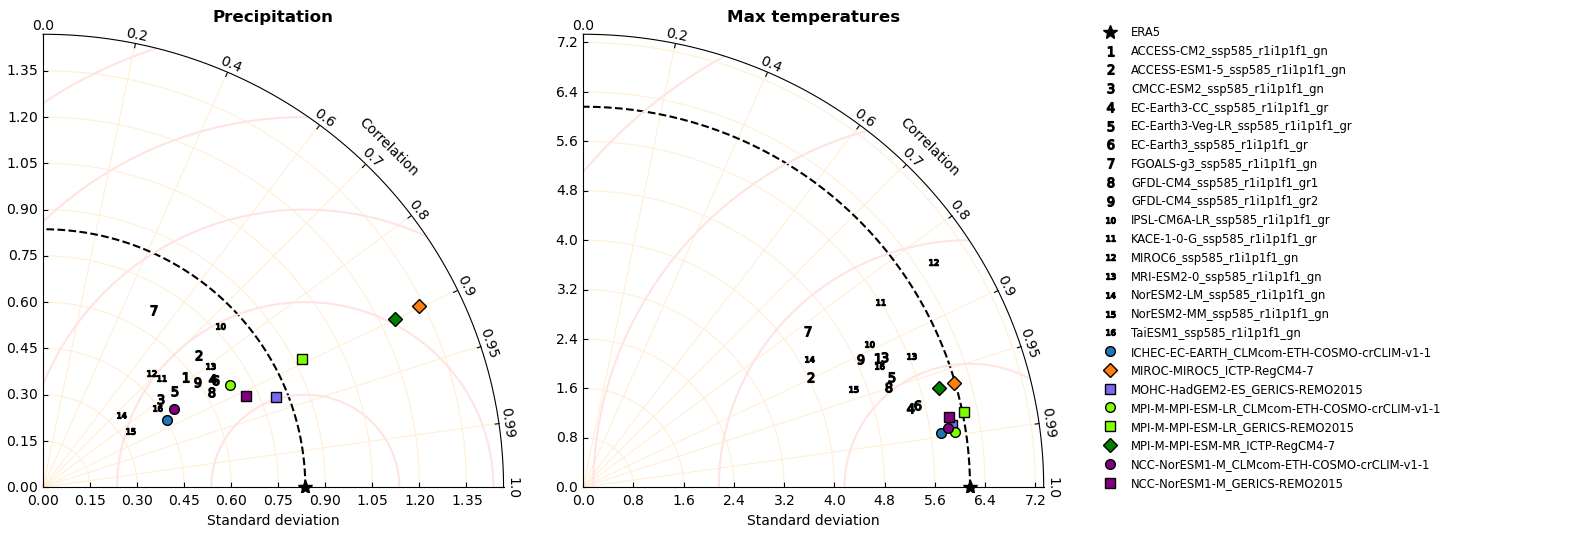

In [42]:
# plot
fig, axs = plt.subplots(ncols = 3, figsize = (20,6), dpi= 100, facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace = 0.15)

for ax in axs: 
    ax.set_aspect('equal')
    ax.set_axis_off()
    
for i in range(2):
    
    # extract SDs & correlations for current variable
    corrs, sds, ref_sd = [pr_scores, tmax_scores, tmin_scores][i]
    
    # create the Taylor Diagram axes
    td = TaylorDiagram(ref_sd, fig = fig, rect=130+i+1, srange = [0,max(sds / ref_sd) * 1.1], label="ERA5")
    td.add_contours(colors = "mistyrose")                                   # lines of equal RMSE
    td.add_grid(color = "papayawhip")                                       # lines of equal correlation & SD
    axs[i].set_title(["Precipitation", "Max temperatures", "Min temperatures"][i], fontweight = "bold")
    
    # add points
    for j in range(len(cmip6_models)):
        td.add_sample(sds[j], corrs[j], marker = "$"+str(j+1)+"$", ms = 7, ls = '', mfc = "tab:blue", mec = "black", label = cmip6_models[j])
        
    l = len(cmip6_models)
    for j in range(l, len(corrs)-1):
        mdl = cordex_models[j-l]
        td.add_sample(sds[j], corrs[j], marker = cordex_markers[mdl.split("_")[1]], ms = 7, ls = '', mfc = cordex_colours[mdl.split("_")[0]], mec = "black", label = mdl)
        
fig.legend(td.samplePoints, [ p.get_label() for p in td.samplePoints ], numpoints=1, prop=dict(size='small'),
           loc='center left', bbox_to_anchor = (0.65,0.5), ncols = 1, edgecolor = "w")

plt.savefig("taylor-diagram_syria-iran-drought.png") 

---
# **Joint distribution**

### **Convert netcdf to .dat**

In [72]:
for fnm in glob.glob("ts/*.nc"):
    ds = xr.open_dataset(fnm)
    if "time" in ds.dims: ds = ds.assign_coords(time = ds.time.dt.year).rename(time = "year")

    ds.to_dataframe().to_csv(re.sub("nc", "csv", fnm))

## **PR-PET-SPEI contours**

In [73]:
import json     # for loading lists produced in R
import lmoments3.distr                     # for SPEI calibration: install using `pip install git+https://github.com/OpenHydrology/lmoments3.git`
glo = getattr(lmoments3.distr, "glo") 

AttributeError: QuadMesh.set() got an unexpected keyword argument 'increasing'

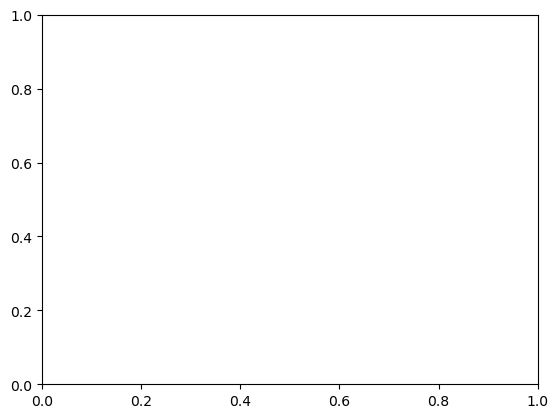

In [102]:
# dummy plot just to pick up the colourbar
drought_cbar = drought_map(xr.open_dataset("../23-03_EA-drought/data/cpc_spei24.nc").spei.sel(time = "2022"), increasing = False); plt.close()

In [123]:
rnm = "ir"

# load copula meshes (computed in R)
with open("joint-fit_era5_pr-pet_"+rnm+".json") as f:
    coef, rl_pr, rl_pet, contour_now, contour_cf, joint_ep = json.load(f).values()

In [124]:
joint_ep

{'2023': [28.9648], 'hist': [5412061.1883]}

In [120]:
# load precip & PET, calculate effective precip; use this to compute SPEI over regular grid of pr & pet
df = pd.merge(pd.read_csv("ts/era_pr_"+rnm+".csv", index_col = "year"), pd.read_csv("ts/era_pet_"+rnm+".csv", index_col = "year"), left_index = True, right_index = True)
df["effpr"] = df.tp - df.pet

# compute SPEI on regular grid
spei24_pars = glo.lmom_fit(df.loc[slice("1980", "2010"), "effpr"].copy()).values()

spei_grid = np.array([[norm.ppf(glo.cdf(p - pet, *spei24_pars)) for p in contour_now["x"]] for pet in contour_now["y"]])

labels_2023 = {"ir" : [(900,4250), (900,4290), (900,4320), (900,4350)], "te" : [(1200,4250), (1200,4290), (1200,4300), (1200,4350)]}
labels_hist = {"ir" : [(950,4050), (950,4090), (950,4120), (950,4130)], "te" : [(1250,4050), (1250,4090), (1250,4100), (1250,4130)]}

/tmp/ipykernel_55538/2598900834.py:10: RuntimeWarning: divide by zero encountered in divide
  cs_hist = axs.contour(contour_cf["x"], contour_cf["y"], 1/np.array(contour_cf["z"]).transpose(), levels = yy, colors = "darkblue", linestyles = "--")


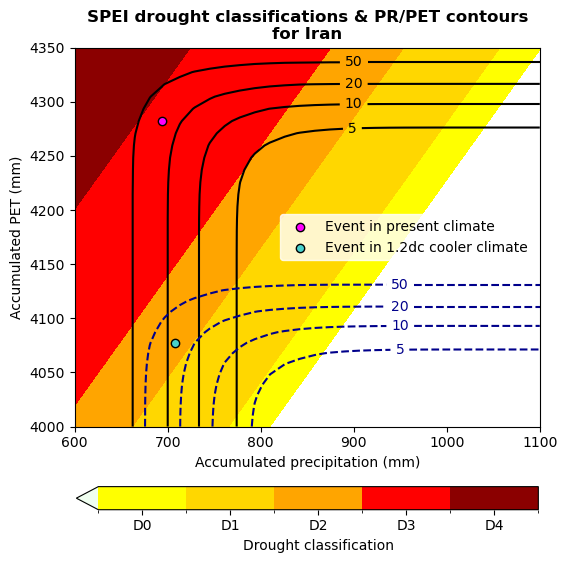

In [126]:
# plot the contours (some cleaning needed)
fig, axs = plt.subplots(ncols = 1, figsize = (6,6), dpi = 100)
yy = [5,10,20,50]

axs.contourf(contour_now["x"], contour_now["y"], spei_grid, levels = [-np.inf, -2, -1.55, -1.25, -.75, -.5], colors = ['darkred', 'red', 'orange', 'gold','yellow','honeydew'])

cs = axs.contour(contour_now["x"], contour_now["y"], 1/np.array(contour_now["z"]).transpose(), levels = yy, colors = "k")
plt.clabel(cs, levels = yy, manual = labels_2023[rnm])

cs_hist = axs.contour(contour_cf["x"], contour_cf["y"], 1/np.array(contour_cf["z"]).transpose(), levels = yy, colors = "darkblue", linestyles = "--")
plt.clabel(cs_hist, levels = yy, manual = labels_hist[rnm])

axs.scatter(rl_pr["2023"][0], rl_pet["2023"], marker = "o", color = "magenta", edgecolor = "k", zorder = 10, label = "Event in present climate")
axs.scatter(rl_pr["hist"][0], rl_pet["hist"], marker = "o", color = "mediumturquoise", edgecolor = "k", zorder = 10, label = "Event in 1.2dc cooler climate")

axs.set_xlabel("Accumulated precipitation (mm)")
axs.set_ylabel("Accumulated PET (mm)")

axs.legend(loc = "center right", edgecolor = "w")
drought_colorbar(drought_cbar, axs, fraction = 0.05, pad = 0.13, label = "Drought classification")

plt.title("SPEI drought classifications & PR/PET contours\nfor "+{"ir" : "Iran", "te" : "Tigris-Euphrates basin"}[rnm], fontweight = "bold")

plt.savefig("fig/fig_era5_joint-drought-classification-contours_"+rnm+".png")